In [2]:
import pandas as pd

df = pd.read_csv("../data_wind_profiles/region3_wind_profile_dataset.csv")
df.head()


,HorWindV,RotSpeed,GenPwr,BlPitch1
0,19.22,12.01,5035.0,14.80
1,19.16,11.97,5031.0,14.82
2,19.54,12.00,5006.0,14.82
3,19.88,11.95,5006.0,14.81
4,20.41,11.98,5004.0,14.79


In [5]:
from sklearn.model_selection import train_test_split

# Separate input features (X) and target (y)
X = df[["HorWindV", "RotSpeed", "GenPwr"]]
y = df["BlPitch1"]

# Train/Val/Test split: 70/15/15
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42)
X_val, X_test, y_val, y_test   = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)

len(X_train), len(X_val), len(X_test)


(1344, 288, 288)

In [7]:
from sklearn.preprocessing import MinMaxScaler


In [9]:
scaler = MinMaxScaler()

# Fit only on training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform val & test
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


In [11]:
X_train_scaled.shape, X_val_scaled.shape, X_test_scaled.shape


((1344, 3), (288, 3), (288, 3))

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

# Create and train baseline Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Validate on validation set
y_val_pred = lr_model.predict(X_val_scaled)

# Compute metrics
mae_val = mean_absolute_error(y_val, y_val_pred)
r2_val = r2_score(y_val, y_val_pred)

mae_val, r2_val


(1.8818220069982274, 0.7445712765707821)

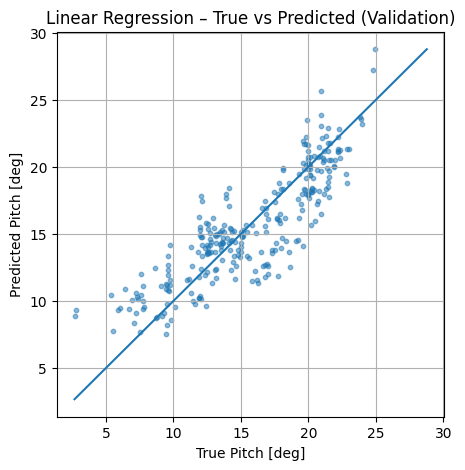

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Convert to numpy for plotting
y_val_true = y_val.values
y_val_pred_lr = y_val_pred  # from linear regression

plt.figure(figsize=(5,5))
plt.scatter(y_val_true, y_val_pred_lr, alpha=0.5, s=10)

# 45-degree reference line
min_val = min(y_val_true.min(), y_val_pred_lr.min())
max_val = max(y_val_true.max(), y_val_pred_lr.max())
plt.plot([min_val, max_val], [min_val, max_val])

plt.xlabel("True Pitch [deg]")
plt.ylabel("Predicted Pitch [deg]")
plt.title("Linear Regression – True vs Predicted (Validation)")
plt.grid(True)
plt.show()


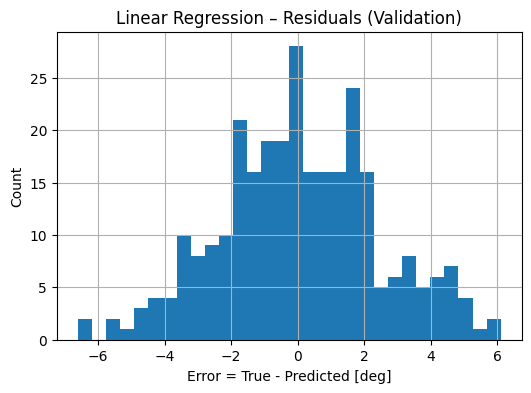

In [17]:
residuals_lr = y_val_true - y_val_pred_lr

plt.figure(figsize=(6,4))
plt.hist(residuals_lr, bins=30)
plt.xlabel("Error = True - Predicted [deg]")
plt.ylabel("Count")
plt.title("Linear Regression – Residuals (Validation)")
plt.grid(True)
plt.show()


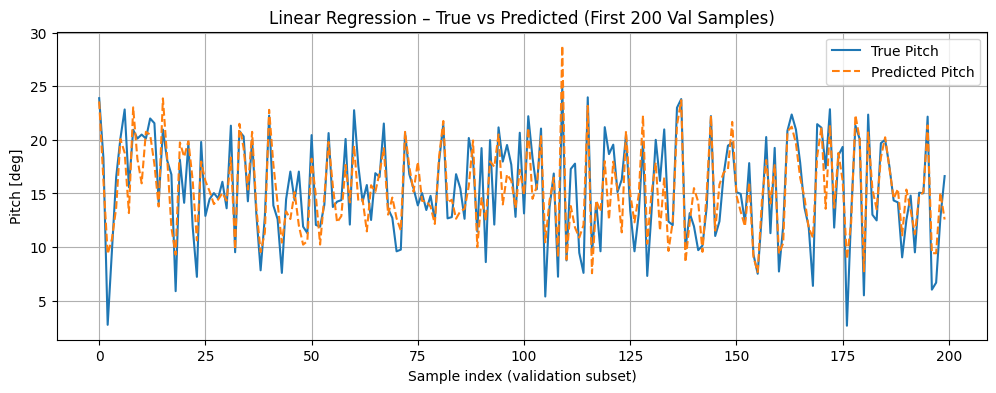

In [19]:
# Reset index so time order is contiguous
y_val_series = y_val.reset_index(drop=True)
y_val_pred_series = pd.Series(y_val_pred_lr)

n = 200  # number of points to show

plt.figure(figsize=(12,4))
plt.plot(y_val_series[:n], label="True Pitch")
plt.plot(y_val_pred_series[:n], label="Predicted Pitch", linestyle="--")
plt.xlabel("Sample index (validation subset)")
plt.ylabel("Pitch [deg]")
plt.title("Linear Regression – True vs Predicted (First 200 Val Samples)")
plt.legend()
plt.grid(True)
plt.show()


In [21]:
from sklearn.ensemble import RandomForestRegressor


In [23]:
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_scaled, y_train)


,n_estimators,200
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [25]:
y_val_pred_rf = rf_model.predict(X_val_scaled)


In [27]:
mae_val_rf = mean_absolute_error(y_val, y_val_pred_rf)
r2_val_rf = r2_score(y_val, y_val_pred_rf)

mae_val_rf, r2_val_rf


(1.196049652777779, 0.8615103309164196)

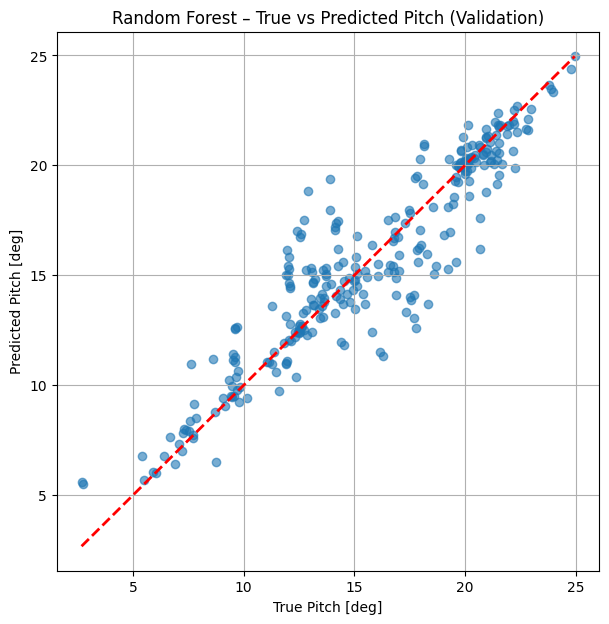

In [29]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(7,7))
plt.scatter(y_val, y_val_pred_rf, alpha=0.6)
plt.plot([y_val.min(), y_val.max()],
         [y_val.min(), y_val.max()],
         'r--', linewidth=2)

plt.xlabel("True Pitch [deg]")
plt.ylabel("Predicted Pitch [deg]")
plt.title("Random Forest – True vs Predicted Pitch (Validation)")
plt.grid(True)
plt.show()


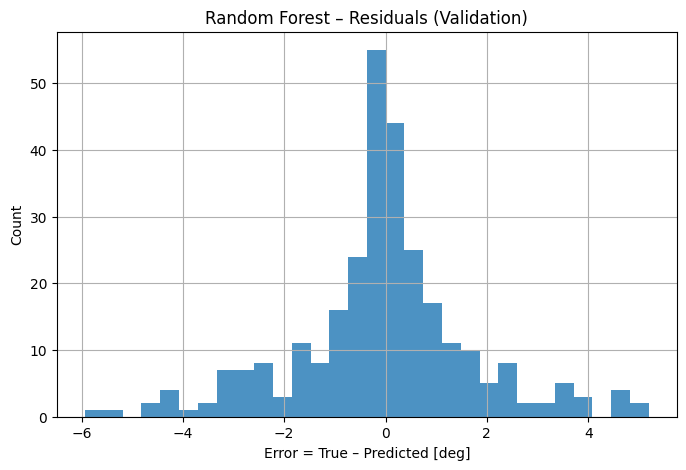

In [31]:
residuals_rf = y_val - y_val_pred_rf

plt.figure(figsize=(8,5))
plt.hist(residuals_rf, bins=30, alpha=0.8)
plt.xlabel("Error = True – Predicted [deg]")
plt.ylabel("Count")
plt.title("Random Forest – Residuals (Validation)")
plt.grid(True)
plt.show()


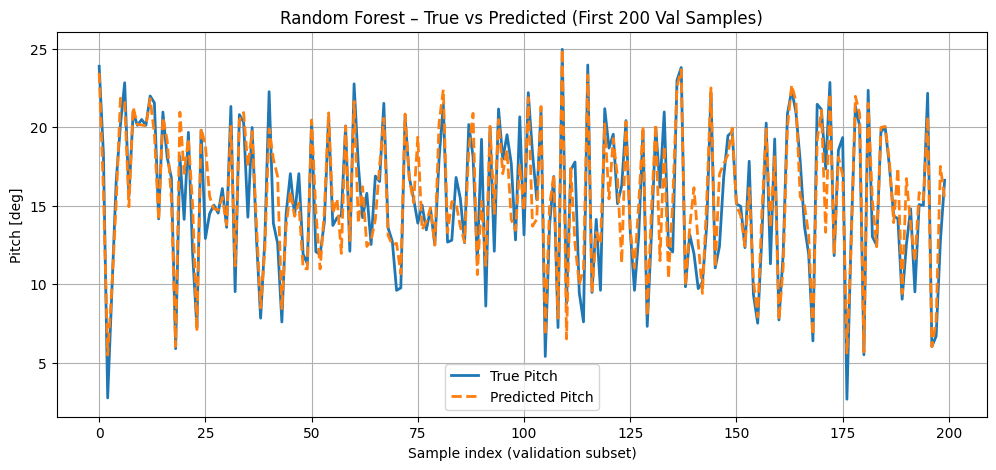

In [33]:
plt.figure(figsize=(12,5))
plt.plot(y_val.values[:200], label="True Pitch", linewidth=2)
plt.plot(y_val_pred_rf[:200], label="Predicted Pitch", linestyle='--', linewidth=2)

plt.xlabel("Sample index (validation subset)")
plt.ylabel("Pitch [deg]")
plt.title("Random Forest – True vs Predicted (First 200 Val Samples)")
plt.legend()
plt.grid(True)
plt.show()


In [35]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, r2_score

mlp_model = MLPRegressor(
    hidden_layer_sizes=(64, 64),
    activation="relu",
    solver="adam",
    learning_rate_init=0.001,
    max_iter=2000,
    random_state=42
)

# Train on scaled training data
mlp_model.fit(X_train_scaled, y_train)

# Predict on validation set
y_val_pred_mlp = mlp_model.predict(X_val_scaled)

# Metrics
mae_val_mlp = mean_absolute_error(y_val, y_val_pred_mlp)
r2_val_mlp = r2_score(y_val, y_val_pred_mlp)

mae_val_mlp, r2_val_mlp


(1.8179105012174892, 0.765833913034502)

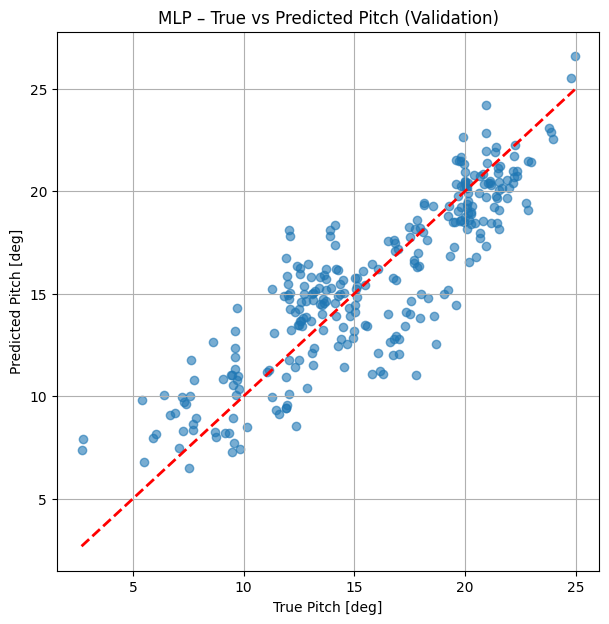

In [37]:
import matplotlib.pyplot as plt
import numpy as np

y_val_true = y_val.values
y_val_pred_mlp_arr = y_val_pred_mlp  # from MLP

plt.figure(figsize=(7,7))
plt.scatter(y_val_true, y_val_pred_mlp_arr, alpha=0.6)
plt.plot([y_val_true.min(), y_val_true.max()],
         [y_val_true.min(), y_val_true.max()],
         'r--', linewidth=2)

plt.xlabel("True Pitch [deg]")
plt.ylabel("Predicted Pitch [deg]")
plt.title("MLP – True vs Predicted Pitch (Validation)")
plt.grid(True)
plt.show()


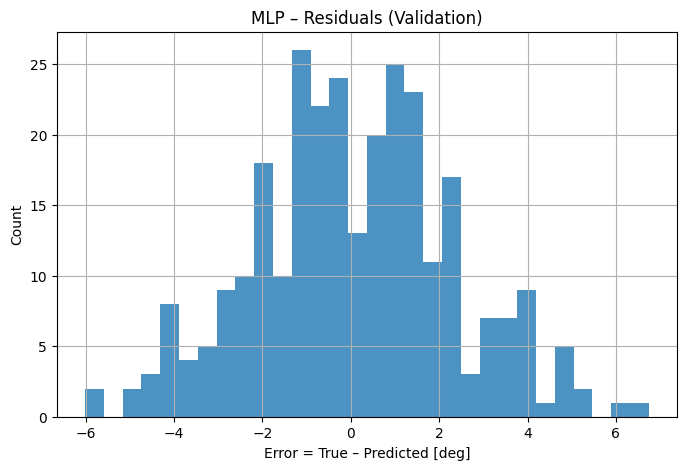

In [39]:
residuals_mlp = y_val_true - y_val_pred_mlp_arr

plt.figure(figsize=(8,5))
plt.hist(residuals_mlp, bins=30, alpha=0.8)
plt.xlabel("Error = True – Predicted [deg]")
plt.ylabel("Count")
plt.title("MLP – Residuals (Validation)")
plt.grid(True)
plt.show()


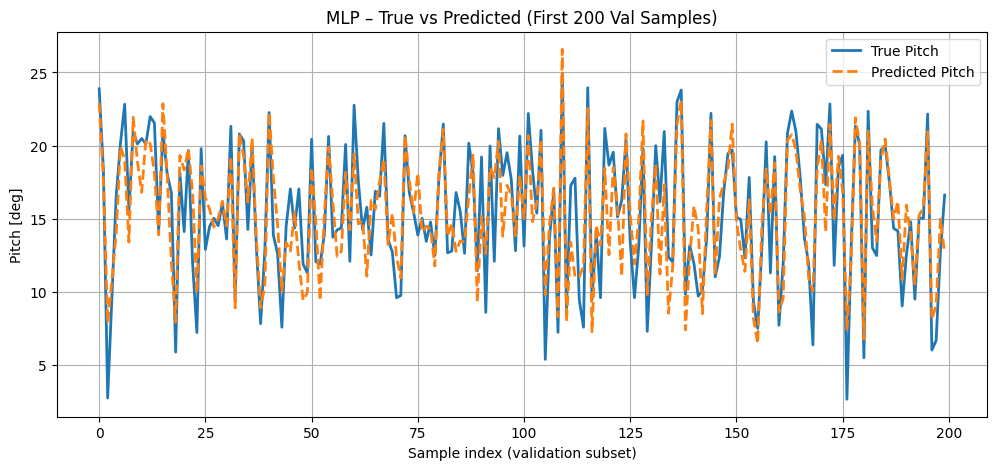

In [41]:
plt.figure(figsize=(12,5))
plt.plot(y_val.values[:200], label="True Pitch", linewidth=2)
plt.plot(y_val_pred_mlp_arr[:200], label="Predicted Pitch", linestyle="--", linewidth=2)

plt.xlabel("Sample index (validation subset)")
plt.ylabel("Pitch [deg]")
plt.title("MLP – True vs Predicted (First 200 Val Samples)")
plt.legend()
plt.grid(True)
plt.show()


In [43]:
import pandas as pd

results = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest", "MLP (Neural Net)"],
    "MAE_val": [mae_val, mae_val_rf, mae_val_mlp],
    "R2_val": [r2_val, r2_val_rf, r2_val_mlp],
})

results_sorted = results.sort_values(by="R2_val", ascending=False).reset_index(drop=True)
results_sorted


,Model,MAE_val,R2_val
0,Random Forest,1.196050,0.861510
1,MLP (Neural Net),1.817911,0.765834
2,Linear Regression,1.881822,0.744571


In [45]:
import joblib
import os

os.makedirs("../models_wind_profile", exist_ok=True)

joblib.dump(rf_model, "../models_wind_profile/rf_wind_profile_model.pkl")
joblib.dump(scaler, "../models_wind_profile/scaler_wind_profile.pkl")

"Saved successfully!"


'Saved successfully!'

In [47]:
# Final evaluation of Random Forest on TEST set
y_test_pred_rf = rf_model.predict(X_test_scaled)

from sklearn.metrics import mean_absolute_error, r2_score

mae_test_rf = mean_absolute_error(y_test, y_test_pred_rf)
r2_test_rf = r2_score(y_test, y_test_pred_rf)

mae_test_rf, r2_test_rf


(1.0996667187500002, 0.89211337791675)

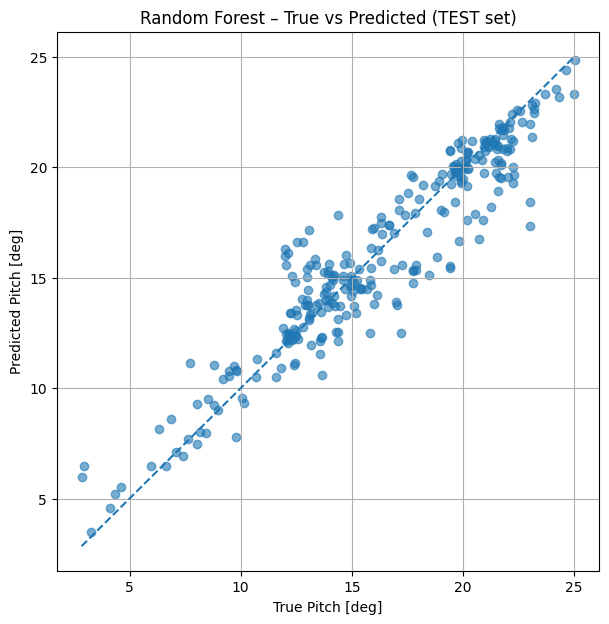

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,7))
plt.scatter(y_test, y_test_pred_rf, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         linestyle='--')

plt.xlabel("True Pitch [deg]")
plt.ylabel("Predicted Pitch [deg]")
plt.title("Random Forest – True vs Predicted (TEST set)")
plt.grid(True)
plt.show()


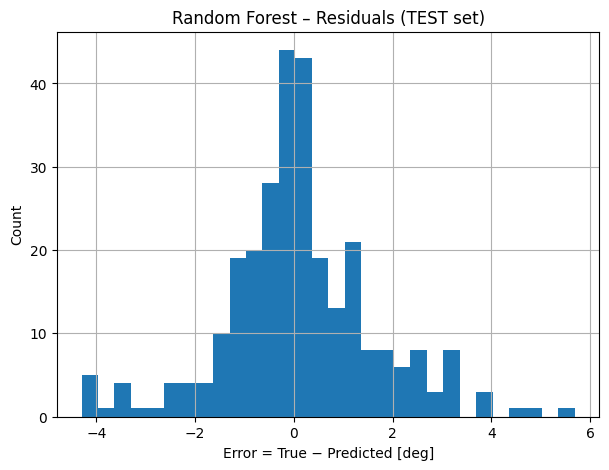

In [51]:
residuals_test = y_test - y_test_pred_rf

plt.figure(figsize=(7,5))
plt.hist(residuals_test, bins=30)
plt.xlabel("Error = True − Predicted [deg]")
plt.ylabel("Count")
plt.title("Random Forest – Residuals (TEST set)")
plt.grid(True)
plt.show()


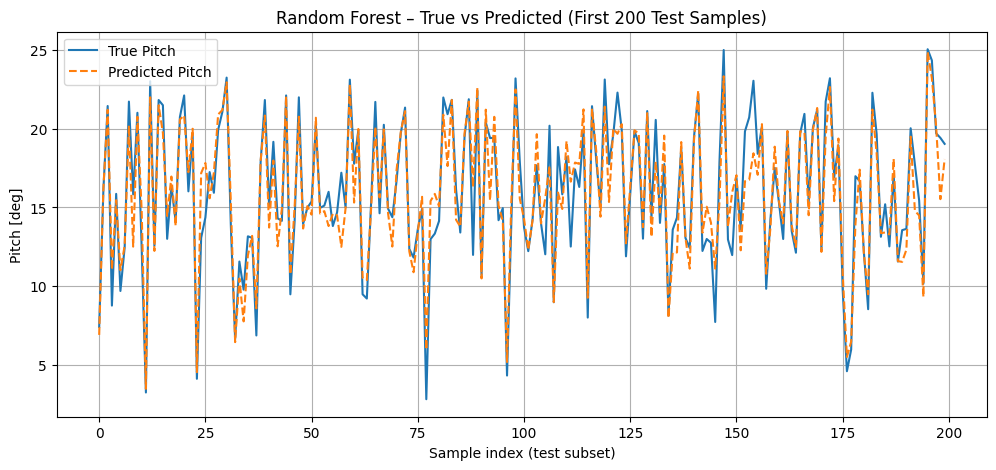

In [52]:
plt.figure(figsize=(12,5))
plt.plot(y_test[:200].reset_index(drop=True), label="True Pitch")
plt.plot(pd.Series(y_test_pred_rf[:200]), 
         linestyle='--', label="Predicted Pitch")

plt.xlabel("Sample index (test subset)")
plt.ylabel("Pitch [deg]")
plt.title("Random Forest – True vs Predicted (First 200 Test Samples)")
plt.legend()
plt.grid(True)
plt.show()
